In [1]:
import numpy as np
import pandas as pd
import math
import fnmatch
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
import seaborn as sns
import tempfile
import tensorflow as tf
from IPython import display
import os
import glob
from tensorflow.data import Dataset
import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics

Using TensorFlow backend.


In [0]:
#tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows=10
pd.options.display.float_format='{:.1f}'.format

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(images, labels), (test_images, test_labels) = fashion_mnist.load_data()
images.shape,labels.shape,test_images.shape,test_labels.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

we have 60000 images, lets use them for training and validation.
we have 10000 images saperately for testing.

In [0]:
def prepare_features(images,labels,shuffle=False):
  images = images.reshape((images.shape[0],images.shape[1]*images.shape[2]))
  labels = labels.reshape((-1,1))
  
  images = pd.DataFrame(images)
  labels = pd.DataFrame(labels)
  
  if shuffle==True:
    idx = np.random.permutation(images.index)
    images = images.reindex(idx)
    labels = labels.reindex(idx)
  
  images = images/255
  
  return images,labels

In [5]:
images,labels = prepare_features(images,labels,shuffle=True)
test_images,test_labels = prepare_features(test_images,test_labels)
train_images, validation_images,train_labels,validation_labels = train_test_split(images,labels,stratify=labels,test_size=0.1)
train_images.shape,train_labels.shape,validation_images.shape,validation_labels.shape,test_images.shape,test_labels.shape

((54000, 784), (54000, 1), (6000, 784), (6000, 1), (10000, 784), (10000, 1))

lets take only first 10000 training images, 1000 validatation images and 1000 testing images

In [0]:
train_images = train_images.head(10000)
train_labels = train_labels.head(10000)
validation_images = validation_images.head(1000)
validation_labels = validation_labels.head(1000)
test_images = test_images.head(1000)
test_labels = test_labels.head(1000)

In [7]:
train_images.shape,train_labels.shape,validation_images.shape,validation_labels.shape,test_images.shape,test_labels.shape

((10000, 784), (10000, 1), (1000, 784), (1000, 1), (1000, 784), (1000, 1))

In [8]:
print("labels:",np.unique(labels.values))

labels: [0 1 2 3 4 5 6 7 8 9]


In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

our data is ready in shape, we have :
 10000 training examples,
  1000 validation examples,
  1000 testing examples.
  
  and we can see that we have total of 10 labels.



lets plot one random example

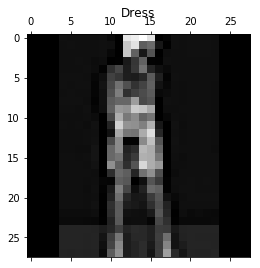

In [10]:
random_choice = np.random.choice(train_images.index)
label = train_labels.loc[random_choice:random_choice,:].values[0][0]
image = train_images.loc[random_choice:random_choice,:].values.reshape(28,28)

plt.matshow(image,cmap="gray")
plt.grid(False)
plt.title(class_names[label])
plt.show()

lets build input functions

In [0]:
def train_input_fn(images,labels,batch_size,shuffle=False,num_epochs=None):
  def input_fn():
    r_images={"pixels":images.values}
    r_labels=labels.values
    r_labels = tf.cast(r_labels, tf.int32)#otherwise it throws error during training in input function
    ds = Dataset.from_tensor_slices((r_images,r_labels))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if(shuffle==True):
      ds = ds.shuffle(1000)
    iterator = ds.make_one_shot_iterator()
    images_batch,labels_batch = iterator.get_next()
    return images_batch,labels_batch
  return input_fn

In [0]:
def predict_input_fn(images,labels,batch_size):
  def input_fn():
    r_images={"pixels":images.values}
    r_labels=labels.values
    r_labels = tf.cast(r_labels, tf.int32)#otherwise it throws error during training in input function
    ds = Dataset.from_tensor_slices((r_images,r_labels))
    ds = ds.batch(batch_size)
    iterator = ds.make_one_shot_iterator()
    images_batch,labels_batch = iterator.get_next()
    return images_batch,labels_batch
  return input_fn
    

lets construct feature columns

In [0]:
def construct_feature_columns():
  return set([tf.feature_column.numeric_column("pixels",shape=(784))])

define linear model

In [0]:
def create_model(train_images,train_labels,validation_images,validation_labels,learning_rate,batch_size=100,steps=10,num_epochs=None,shuffle=False):
  
  training_input_fn = train_input_fn(train_images,train_labels,batch_size,shuffle,num_epochs)
  training_validation_input_fn = predict_input_fn(train_images,train_labels,batch_size)
  validating_validation_input_fn = predict_input_fn(validation_images,validation_labels,batch_size)
  
  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5.0)
  
  classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(),
      optimizer=my_optimizer,
      n_classes=10
  )
  
  periods = 10
  steps_per_period = steps/periods
  training_losses=[]
  validation_losses=[]
  
  for period in range(periods):
    
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    training_predictions = classifier.predict(input_fn=training_validation_input_fn)
    training_predictions = [item['class_ids'][0] for item in training_predictions]
    training_predictions = tf.keras.utils.to_categorical(training_predictions,10)
    training_loss = metrics.log_loss(train_labels,training_predictions)
    training_losses.append(training_loss)
    
    validation_predictions = classifier.predict(input_fn=validating_validation_input_fn)
    validation_predictions = [item['class_ids'][0] for item in validation_predictions]
    validation_predictions = tf.keras.utils.to_categorical(validation_predictions,10)
    validation_loss = metrics.log_loss(validation_labels,validation_predictions)
    validation_losses.append(validation_loss)
    
    print("period %d: training loss %d, validation loss %d"%(period,training_loss,validation_loss))
    
  
  
  #training_validation_input_fn = predict_input_fn(train_images,train_labels,batch_size)
  final_training_predictions = classifier.predict(input_fn=training_validation_input_fn)
  final_training_predictions = [item['class_ids'][0] for item in final_training_predictions]
  training_accuracy = metrics.accuracy_score(final_training_predictions,train_labels)

  #validating_validation_input_fn = predict_input_fn(validation_images,validation_labels,batch_size) 
  final_validating_predictions = classifier.predict(input_fn=validating_validation_input_fn)
  final_validating_predictions = [item['class_ids'][0] for item in final_validating_predictions]
  validating_accuracy = metrics.accuracy_score(final_validating_predictions,validation_labels)

  print("\naccuracy on training data is",training_accuracy,"and on validating data is %d ",validating_accuracy)
  
  plt.plot(training_losses,label="training loss")
  plt.plot(validation_losses,label="validation loss")
  plt.xlabel("period")
  plt.ylabel("loss")
  plt.show()
  
  cm = metrics.confusion_matrix(validation_labels,final_validating_predictions)
  cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
  ax=sns.heatmap(cm_normalized,cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()
  
  return classifier
    
    

In [0]:
learning_rate = 0.02
batch_size=10
num_epochs=5
shuffle=True
steps=1000
classifier = create_model(train_images,train_labels,validation_images,validation_labels,learning_rate,batch_size,steps,num_epochs,shuffle)

In [40]:
validating_test_input_fn = predict_input_fn(test_images,test_labels,batch_size) 
final_testing_predictions = classifier.predict(input_fn=validating_test_input_fn)
final_testing_predictions = [item['class_ids'][0] for item in final_testing_predictions]
test_accuracy = metrics.accuracy_score(final_testing_predictions,test_labels)

print("accuracy on test data is ",test_accuracy)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpxymwvs8d/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
accuracy on test data is  0.806


now try to build neural network classifier

In [0]:
tf.estimator.DNNClassifier?

In [43]:
my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5.0)
 
nn_classifier = tf.estimator.DNNClassifier(
      hidden_units=[10,10],
      feature_columns=construct_feature_columns(),
      optimizer=my_optimizer,
      n_classes=10
  )

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpkthix4yy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1d0055b588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [45]:
nn_classifier.train(
        input_fn=train_input_fn(train_images,train_labels,100,True,2),
        steps=100
    )

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpkthix4yy/model.ckpt.
INFO:tensorflow:loss = 234.67276, step = 0
INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpkthix4yy/model.ckpt.
INFO:tensorflow:Loss for final step: 76.352196.


In [0]:
def create_dnn_model(train_images,train_labels,validation_images,validation_labels,learning_rate,batch_size=100,steps=10,num_epochs=None,shuffle=False,hidden_units=[10,10]):
  
  training_input_fn = train_input_fn(train_images,train_labels,batch_size,shuffle,num_epochs)
  training_validation_input_fn = predict_input_fn(train_images,train_labels,batch_size)
  validating_validation_input_fn = predict_input_fn(validation_images,validation_labels,batch_size)
  
  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5.0)
  
  classifier = tf.estimator.DNNClassifier(
      hidden_units = hidden_units,
      feature_columns=construct_feature_columns(),
      optimizer=my_optimizer,
      n_classes=10
  )
  
  periods = 10
  steps_per_period = steps/periods
  training_losses=[]
  validation_losses=[]
  
  for period in range(periods):
    
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    training_predictions = classifier.predict(input_fn=training_validation_input_fn)
    training_predictions = [item['class_ids'][0] for item in training_predictions]
    training_predictions = tf.keras.utils.to_categorical(training_predictions,10)
    training_loss = metrics.log_loss(train_labels,training_predictions)
    training_losses.append(training_loss)
    
    validation_predictions = classifier.predict(input_fn=validating_validation_input_fn)
    validation_predictions = [item['class_ids'][0] for item in validation_predictions]
    validation_predictions = tf.keras.utils.to_categorical(validation_predictions,10)
    validation_loss = metrics.log_loss(validation_labels,validation_predictions)
    validation_losses.append(validation_loss)
    
    print("period %d: training loss %d, validation loss %d"%(period,training_loss,validation_loss))
    
  
  
  #training_validation_input_fn = predict_input_fn(train_images,train_labels,batch_size)
  final_training_predictions = classifier.predict(input_fn=training_validation_input_fn)
  final_training_predictions = [item['class_ids'][0] for item in final_training_predictions]
  training_accuracy = metrics.accuracy_score(final_training_predictions,train_labels)

  #validating_validation_input_fn = predict_input_fn(validation_images,validation_labels,batch_size) 
  final_validating_predictions = classifier.predict(input_fn=validating_validation_input_fn)
  final_validating_predictions = [item['class_ids'][0] for item in final_validating_predictions]
  validating_accuracy = metrics.accuracy_score(final_validating_predictions,validation_labels)

  print("\naccuracy on training data is",training_accuracy,"and on validating data is %d ",validating_accuracy)
  
  plt.plot(training_losses,label="training loss")
  plt.plot(validation_losses,label="validation loss")
  plt.xlabel("period")
  plt.ylabel("loss")
  plt.show()
  
  cm = metrics.confusion_matrix(validation_labels,final_validating_predictions)
  cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
  ax=sns.heatmap(cm_normalized,cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()
  
  return classifier
    
    

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpt3utnrro', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1d09912da0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done c

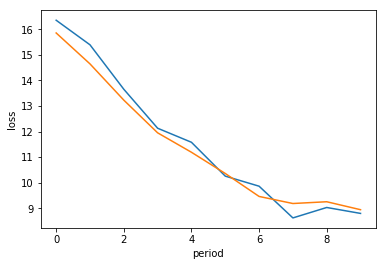

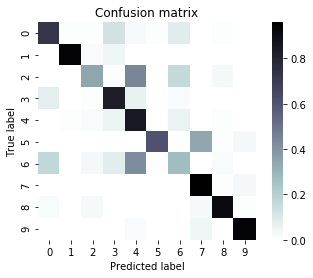

In [48]:
learning_rate = 0.02
batch_size=10
num_epochs=5
shuffle=True
steps=1000
hidden_units=[10,10]
classifier = create_dnn_model(train_images,train_labels,validation_images,validation_labels,learning_rate,batch_size,steps,num_epochs,shuffle,hidden_units)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpy_3gt4iv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1d0063cac8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done c

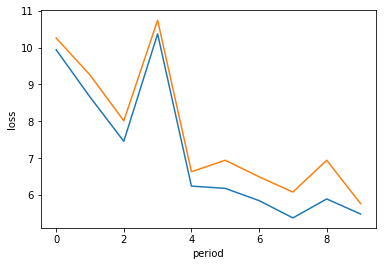

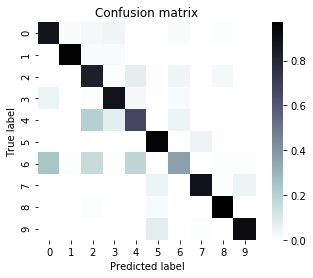

In [52]:
learning_rate=0.05
steps=1000
batch_size=30
hidden_units=[100, 100]
num_epochs=5
shuffle=True
nn_classifier = create_dnn_model(train_images,train_labels,validation_images,validation_labels,learning_rate,batch_size,steps,num_epochs,shuffle,hidden_units)

In [53]:
validating_test_input_fn = predict_input_fn(test_images,test_labels,batch_size) 
final_testing_predictions = nn_classifier.predict(input_fn=validating_test_input_fn)
final_testing_predictions = [item['class_ids'][0] for item in final_testing_predictions]
test_accuracy = metrics.accuracy_score(final_testing_predictions,test_labels)

print("accuracy on test data is ",test_accuracy)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpy_3gt4iv/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
accuracy on test data is  0.82


visualize the weights of first hidden layer

In [77]:
nn_classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

['dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adagrad', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adagrad', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adagrad', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adagrad', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adagrad', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adagrad', 'global_step']
weights0 shape: (784, 10)


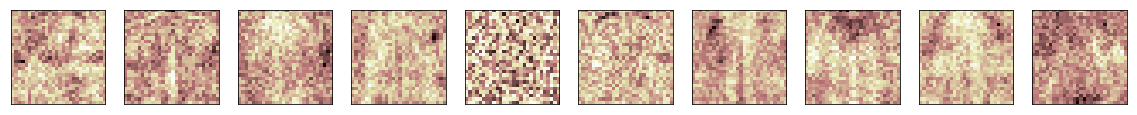

In [80]:
print(nn_classifier.get_variable_names())

weights0 = classifier.get_variable_value("dnn/hiddenlayer_0/kernel")

print("weights0 shape:", weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(20, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.pink)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()